# Super organised modular notebook


## Imports and installation

You can install the packages needed using the following command `pip install -r requirements.txt`  where the file contains the following:

<div class="alert alert-block alert-info">

aiohttp==3.9.5\
asyncio==3.4.3\
igraph\
requests\
py4cytoscape==1.9.0\
pandas\
tqdm==4.66.2\
numpy\
matplotlib\
json\
nest_asyncio\
jsonpath_ng\
ruamel.yaml\
cwl_utils
</div>

Please note that Cytoscape has to be installed and open on your machine for visualisation to work.

In [103]:
# General packages
import pandas as pd         
import os
from tqdm import tqdm       
import pickle
import numpy as np
from datetime import datetime, timedelta
import glob
import sys
import matplotlib.pyplot as plt
import json


# define format, and set parameters for time, TODO: rm?  
date_format = "%Y_%m_%d_%H_%M" 
current_date = datetime.now().strftime(date_format)
last_week_date = (datetime.now() - timedelta(days=7)).strftime(date_format)



# Project specific packages
import aiohttp              # Used for aggregating requests into single session
import asyncio              # -"-
import nest_asyncio         # For jupyter asyncio compatibility 
nest_asyncio.apply()        # Automatically takes into account how jupyter handles running event loops
import jsonpath_ng as jp


# TODO: import jsonpath_ng.ext      # More efficient json processing look into if actually computationally more efficient 
import igraph               # Used to create te citationa graph 
import requests             # For single API requests 

# workflow parsing 
from cwl_utils.parser import load_document_by_uri, save # for workflow parsing 
from ruamel import yaml



# Visualisation 
import py4cytoscape as p4c  # Cytoscape for visualisation of the citaton graph, 
                            # note that Cytoscape has to be installed and open on your machine for visualisation to work

Check that the packages are installed and functional 

In [105]:
print("igraph version:", igraph.__version__)
try: 
    dir(p4c)
    p4c.cytoscape_ping() 
    print("Cytoscape version:",p4c.cytoscape_version_info()['cytoscapeVersion'])    
except:
    print ("Make sure to have Cytoscape installed and open (or don't, if you don't care about the visualisation)!")


igraph version: 0.11.4
Make sure to have Cytoscape installed and open (or don't, if you don't care about the visualisation)!


In cyrest_get: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.


## Downloading data 

In [ ]:
# format: 
"""

    Function description 
    
    Parameters
    ----------
    name : type
        description
"""

'\n\n    Function description \n    \n    Parameters\n    ----------\n    name : type\n        description\n'

In [ ]:
async def aggregate_requests(session, url):
    """ 
    Sync the bio.tools (page) requests so they are all made in a single session 

    Parameters
    ----------
    session : aiohttp.client.ClientSession object
        session object for package aiohttp
    url : str
        url for request
    """
    
    async with session.get(url) as response:
        return await response.json()

In [204]:
async def get_tool_metadata(topicID="topic_0121"):  # TODO: I removed format. Check if there is any reason to have it 
                                                        # TODO: should add parameter for optional forced retrieval - even if csv file, still recreate it 
                                                        # TODO: Currently no timing - add tracker
    """
    Fetches metadata about tools from bio.tools, belonging to a given topicID and returns as a dataframe.
    If a CSV file already exists load the dataframe from it. 

    Parameters
    ----------
    topicID : str TODO: make this a int instead? why am I writing topic? 
        The ID to which the tools belongs to, ex. "Proteomics" or "DNA" as defined by 
        EDAM ontology (visualisation: https://edamontology.github.io/edam-browser/#topic_0003)

    
    """


    # File name checking and creation 
    date_format = "%Y%m%d"
    pattern = f'biotools_metadata_{topicID}*'
    matching_files = glob.glob(pattern)
    
    if matching_files:
        matching_files.sort(key=os.path.getmtime)
        csv_filename = matching_files[-1]
        
        # Check if file older than a week
        file_date = datetime.strptime(csv_filename.split('_')[-1].split('.')[0], date_format)
        if file_date < datetime.now() - timedelta(days=7):
            print("Old datafile. Updating...")
        else:
            print("Bio.tools data loaded from existing CSV file.")
            df = pd.read_csv(csv_filename)
            return df
    else:
        print("No existing bio.tools CSV file. Downloading data.") 
        # Define the CSV filename
        csv_filename = f'biotools_metadata_{topicID}_{datetime.now().strftime(date_format)}.csv' 
    



    
    # TODO: should filepath/name be allowed to be configurable?
    # then the following could be a separate function called by this one, or is this very inefficient?
    # TODO: should place files created in a folder named for each run

    all_tool_data = [] # TODO: predefine the length, means one more request 
    doi_tools = [] # collect tools without pmid

    # start at page 1 
    page = 1 

    # requests are made during single session
    async with aiohttp.ClientSession() as session: 
        while page:
            # if int(page) > 10:
            #     break # for debug 
            # send request for tools on the page, await further requests and return resonse in json format
            biotools_url = f'https://bio.tools/api/t?topicID=%22{topicID}%22&format=json&page={page}'
            biotool_data = await aggregate_requests(session, biotools_url)
            

            # TODO: Do I need to check? what happens if no response for page == 1? Maybe try/except instead
            # Checking if there are any tools, if 

            if 'list' in biotool_data: 
                biotools_lst = biotool_data['list']
                
                for tool in biotools_lst: #add tqdm here 
                    name = tool.get('name') 
                    publications = tool.get('publication') # does this cause a problem if there is no publication? 
                    topic = tool.get('topic')
                    
                    if isinstance(publications, list): # ahh how many ifs will it bee aahh 
                        try:
                            for publication in publications:
                                if publication.get('type')[0] == 'Primary':
                                    primary_publication = publication
                                    break
                        except:
                            primary_publication = publications[0] # pick first then 
                    else:
                        primary_publication = publications
                        

                    if primary_publication.get('pmid'):
                        all_tool_data.append({
                            'name': name,
                            'pmid': str(primary_publication['pmid']),
                            'topic': topic[0]['term']
                        })
                    else:
                        
                        doi_tools.append({
                            'name': name,
                            'doi': primary_publication.get('doi'),
                            'topic': topic[0]['term']
                        })

                page = biotool_data.get('next')
                if page: # else page will be None and loop will stop 
                    page = page.split('=')[-1] # only want the page number 
            else: 
                print(f'Error while fetching tool names from page {page}')
                break
    
    # Download pmids from dois
    doi_library_filename = 'doi_pmid_library.json' # TODO: Make it customisable 
    try: 
        with open(doi_library_filename, 'r') as f:
            doi_library = json.load(f)
    except FileNotFoundError:
        print(f'Library file not found. Creating new file named {doi_library_filename}.')
        doi_library = {} # {doi: pmid}, should I perhaps do {name: [pmid doi ]} instead?

    library_updates = False


    async with aiohttp.ClientSession() as session: 
        for tool in tqdm(doi_tools, desc="Fetching pmids from dois."):
            doi = tool["doi"]

            # Check if tool is already in library 
            if doi in doi_library: 
                doi_pmid = doi_library[doi] 
                print("doi already in library")
                tool["pmid"] = doi_pmid
                print(tool["pmid"])
                continue
            
            # Otherwise access NCBI API
            library_updates = True

            url = f"http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=PubMed&retmode=json&term={doi}"
            result = await aggregate_requests(session, url)
            try:
                doi_pmid = str(result.get('esearchresult').get('idlist')[0])
                print(doi_pmid)
                if str(doi_pmid) == 'null': #this does not feel optimal 
                    doi_pmid = None
            except:
                doi_pmid = None # if no pmid was found, will have to remove these nodes later

            
            tool["pmid"] = doi_pmid

            if doi_pmid: # do not want to include Nones, since they might get updated in future
                doi_library[doi] = doi_pmid

    if library_updates:
        print(f"Writing new doi, pmid pairs to file {doi_library_filename}")
        with open(doi_library_filename, 'w') as f:
            json.dump(doi_library, f)

    # Convert list of dictionaries to dataframe
    df_pmid = pd.DataFrame(all_tool_data)
    df_doi = pd.DataFrame(doi_tools)


    #drop column doi, and drop all rows with "pmid == None" and concatenate them. TODO: maybe export to logfile which ones did not have pmid or doi pmid 
    df_doi.drop(columns=["doi"], inplace=True)
    
    df_doi = df_doi.dropna(subset=["pmid"])
    df = pd.concat([df_pmid, df_doi], axis=0, ignore_index=True)
    # Save dataframe to file
    df.to_csv(csv_filename, index=False)

    # If there were any pages, check how many tools were retrieved and how many tools had pmids
    if biotool_data: 
        nr_tools = int(biotool_data['count']) 
        nr_included_tools = len(all_tool_data) + len(doi_tools)
        print(f'Found {nr_included_tools} out of a total of {nr_tools} tools with PMIDS.')

    return df

In [109]:
def europepmc(article_id, format='JSON', source='MED', page=1, page_size=1000):   # TODO: replace own wrapper with recommendation? https://github.com/ML4LitS/CAPITAL/tree/main
                                                                                # TODO: call output="idlist" immidiately? then we have no metadata but we dont use that anyways!
    """ 
    Downloads pmids for the articles citing the given article_id, returns list of citation pmids (PubMed IDs)
        
    Parameters
    ----------
    article_id : str # TODO: int? 
        pmid, PubMed ID, for a given article.
    source: str
        source ID as given by the EuropePMC API documentation: https://europepmc.org/Help#contentsources 

    page, int, default == 1
        determines where to start looking TODO: remove this, why would you not start at 1? 

    pagesize, int, default 1000 max 1000
        determines number of results per page
    
    """ 

    # create a url with the given requirements according to the EuropePMC API synthax and query the API
    base_url = f'https://www.ebi.ac.uk/europepmc/webservices/rest/{source}/{article_id}/citations?page={page}&pageSize={page_size}&format={format}'
    result = requests.get(base_url)

    # Return all citations, given the query was accepted
    # TODO: jsonpath-ng
    if result.ok:
        return result.json()['citationList']['citation']
    else:
        print('Something went wrong') # TODO: better error message. Try/except? 


## Graph generation

The function reate_citation_network can be called to create or load the cocitation network

In [ ]:
#TODO: all of the descriptions - Where do I put default value? 

In [235]:
def create_citation_network(topicID="topic_0121", testSize=None, randomSeed=42, loadData=True, filePath='', outpath = None, inpath = '', saveFiles=True): # TODO: I just threw  code into this function- improve
    
    """
    Creates a citation network given a topic and returns a graph and the tools included in the graph

        
    Parameters
    ----------
    topicID : str, default "topic_0121" (proteomics) TODO: int? 
        The ID to which the tools belongs to, ex. "Proteomics" or "DNA" as defined by 
        EDAM ontology (visualisation: https://edamontology.github.io/edam-browser/#topic_0003)

    testSize : int or None, default None
        Determines the number of tools included in the citation graph.

    randomSeed : int, default 42
        Specifies what seed is used to randomly pick tools in a test run. 
    
    loadData : Boolean, default True
        Determines if already generated graph is loaded or if it is recreated.
    
    filePath : str  TODO: add filepath 
        Path to already generated graph

    saveFiles : Boolean, default True
        Determines if newly generated graph is saved. 

    """
   
        

    # Retrieve the data 
    # run the asynchronous function for single session requests 
    result = asyncio.run(get_tool_metadata(topicID=topicID)) 
    pmids = result['pmid'].tolist() # should I use numpy for all my lists? 

    # Randomly picks out a subset of the pmids
    if testSize: 
        if not loadData:  
            print(f"Creating test-cocitation network of size {testSize}. Random seed is {randomSeed}.")
        np.random.seed(randomSeed)
        pmids = np.random.choice(pmids,testSize)
    else:
        testSize = '' # temp for the creation of files, so they dotn ahve none in name 
    
    # Edge creation 
    # Load previously created data or recreate it

    if loadData: # TODO: pickle maybe is not the way to go in future? 
        edge_path = f'{inpath}/edges{testSize}.pkl'
        graph_path = f'{inpath}/graph{testSize}.pkl'
        tool_path = f'{inpath}/tools{testSize}.pkl'
        
        if os.path.isfile(edge_path) and os.path.isfile(graph_path) and os.path.isfile(tool_path): # should give option to specify these names
            print("Loading saved graph.")
            with open(edge_path, 'rb') as f:
                unq_edges = pickle.load(f) # should be unique ones right 
            with open(graph_path, 'rb') as f:
                G = pickle.load(f) 
            with open(tool_path, 'rb') as f:
                included_tools = pickle.load(f) 
        else:
            print(f"Files not found. Please check that '{edge_path}', '{graph_path}' and '{tool_path}' are in your current directory and run again. Or set loadData = False, to create the files. ")
            return 
   
    else:
         # Create output folder
        if outpath: 
            os.mkdir(outpath) 
        else:
            outpath =  f'out_{datetime.now().strftime("%Y%m%d%H%M")}'
            os.mkdir(outpath)

        # edge creation using europepmc
        print("Downloading citation data from Europepmc.")
        
        # Creates a list of the tools that actually have citations, otherwise they are not included in the graph. 
        included_tools = []  
        edges = []

        # Get citations for each tool, and generate edges between them. 
        for pmid in tqdm(pmids, desc="Processing PMIDs"): 
            pmid = str(pmid) # EuropePMC requires str            
    
            citations = europepmc(pmid, page_size=1000)
            for citation in citations:
                edges.append((pmid, str(citation['id']))) # TODO: this is the wring way around? shoudl be citation to pmid, no? 
                if pmid not in included_tools:
                    included_tools.append(pmid) 
        
        print("Creating citation graph using igraph.")
        
        # Finding unique edges by converting list to a set (because tuples are hashable) and back to list.
        # TODO: better way?
        unq_edges =  list(set(edges)) 
        print(f"{len(unq_edges)} unique out of {len(edges)} edges total!")

        # Creating a directed graph with unique edges
        G = igraph.Graph.TupleList(unq_edges, directed=True)

        # Removing disconnected vertices (that are not tools) that do not have information value for the (current) metric
        # TODO: improve edge removal?
        print("Removing citations with degree less or equal to 1 (Non co-citations).")
        vertices_to_remove = [v.index for v in G.vs if v.degree() <= 1 and v['name'] not in included_tools] 
        G.delete_vertices(vertices_to_remove)
        vertices_to_remove = [v.index for v in G.vs if v.degree() == 0 ] # second run to remove the copletely detatched ones after first run sicne they wont give info anyways. 
        G.delete_vertices(vertices_to_remove) # This will remove isolated tools as well 

        # Updating included_tools to only contain lists that are in the graph  
        included_tools = [tool for tool in included_tools if tool in G.vs['name']] 


        # Saving edges, graph and tools included in the graph 


        if saveFiles:
            edge_path = f'{outpath}/edges{testSize}.pkl'
            graph_path = f'{outpath}/graph{testSize}.pkl'
            tool_path = f'{outpath}/tools{testSize}.pkl'

            print(f"Saving data to '{edge_path}', '{graph_path}' and '{tool_path}'.") # sould make these filenames dynamic
            # and save them 
            #Do this nicer later? 
            with open(edge_path, 'wb') as f:
                pickle.dump(unq_edges, f)

            with open(graph_path, 'wb') as f:
                pickle.dump(G, f)

            with open(tool_path, 'wb') as f:
                pickle.dump(included_tools, f)    

    # returns a graph and the pmids of the tools included in the graph (tools connected by cocitations)
    return G, included_tools 


## The metric

Create the cocitation network specifying if you want to load existing data, run on a smaller test set etc.  

In [239]:
# G, included_tools = create_citation_network(testSize=10, loadData=False)

#TODO: filepath for input files! 

# G, included_tools = create_citation_network(loadData=False, outpath =".")


G, included_tools = create_citation_network(inpath="out")


Bio.tools data loaded from existing CSV file.
Loading saved graph.


### Download workflow data


<div class="alert alert-block alert-warning">
<b>OBS:</b> This is not yet implemented. Currently drawing random tools to simulate workflows
</div>

In [168]:
# TODO: download workflows

# TODO: improve randomisation to have sequential networks

# number of edges in the workflow

def radnomise_workflow(num_pairs = 3):
    workflow_pairs = []
    while len(workflow_pairs) < num_pairs:
        article1 = np.random.choice(included_tools)
        article2 = np.random.choice(included_tools)
        if article1 != article2:  # Ensure article1 and article2 are different
            workflow_pairs.append((article1, article2))

    workflow_tools = np.unique([element for tuple in workflow_pairs for element in tuple])
    return workflow_pairs, workflow_tools
    # print( "Tools in pseudo WF:", workflow_tools)
    # # Print the generated pairs
    # print("Generated workflow pairs (WF edges):")
    # for pair in workflow_pairs:
    #     print(pair)

In [171]:
def parse_workflows(cwl_file):
    # Import CWL Object
    cwl_obj = load_document_by_uri(cwl_file)

    # Extract edges from CWL object
    edges = []
    for step in cwl_obj.steps:
        step_id = step.id.split("#")[-1]
        for input_param in step.in_:
            if input_param.source:
                source_step_id = input_param.source.split('/')[-1].split("#")[-1]
                edges.append((source_step_id, step_id))
        for output_param in step.out:
            edges.append((step_id, output_param.split("/")[-1]))

    # Extract pairwise connections between tools
    pairwise_connections = set()
    for source, target in edges:
        if "_out_" in source:
            tool_id = target.split("_")[0]
            for next_target, next_source in edges:
                if next_source == source:
                    pairwise_connections.add((tool_id, next_target.split("_")[0]))

    # Read CSV file containing tool information
    csv_filename = 'biotools_metadata_topic_0121_20240507.csv' #TODO: this should NOT be hardcoded
    f = pd.read_csv(csv_filename)

    # Retrieve PMID values for pairwise connections, this should be bio.tools ids instead? 
    new_edges = []
    for edge in pairwise_connections:
        source_pmid = f.loc[f['name'] == edge[0], 'pmid'].values[0] if len(f.loc[f['name'] == edge[0], 'pmid']) > 0 else None # neme in small letters too? 
        target_pmid = f.loc[f['name'] == edge[1], 'pmid'].values[0] if len(f.loc[f['name'] == edge[1], 'pmid']) > 0 else None
        if source_pmid is not None and target_pmid is not None:
            new_edges.append((str(source_pmid), str(target_pmid)))

    # Print new edges
    workflow_tools = np.unique([element for tuple in new_edges for element in tuple])

    return new_edges, list(workflow_tools)

    # # Construct graphs
    # G1 = igraph.Graph.TupleList(edges, directed=True)
    # G2 = igraph.Graph.TupleList([(target, source) for source, target in edges], directed=True) # rotated
    # G3 = igraph.Graph.TupleList(pairwise_connections, directed=True)
    # G4 = igraph.Graph.TupleList(new_edges, directed=True)



In [52]:
# static for testing 
workflow_pairs = [('29400476', '14976030'), ('29400476', '14632076'), ('14632076', '14976030')]
workflow_tools = list(np.unique([element for tuple in workflow_pairs for element in tuple]))


In [183]:
cwl_file = "./workflows/candidate_workflow_2.cwl"

workflow_pairs, workflow_tools = parse_workflows(cwl_file) # TODO: more than one at a time 

rand_workflow_pairs, rand_workflow_tools = radnomise_workflow(num_pairs = 3)

print(workflow_pairs, rand_workflow_pairs)

[('29400476', '14632076'), ('14632076', '23148064'), ('29400476', '23148064')] [('20058247', '31384044'), ('32615972', '33323113'), ('34081399', '33416831')]


could add visualisation of the workflows and the original workflows. 

### Calculate metric

<div class="alert alert-block alert-warning">
<b>OBS:</b> This is a simple placeholder implementation of a metric
</div>

In [173]:
def comet(graph, workflows): # cocitation metric 

    """
    Calculates the cocitation  metric for a given workflow and a given cocitation graph
    
    Parameters
    ----------
    graph : igraph.Graph
        Graph generated by igraph
    workflow, list of tuples with pairs of strings TODO: how do I write this? does it matter I wont have this format later anyways? 
        List of tuples of strings corresponding to the edges in the workflow. 

    """
    # List to  collect pairwise scores
    score_list = [] # TODO: can predefine the list length, does not matter this is temporary?

    for pair in workflows:
        cocite_score = 0
        neighbors_of_first = set(graph.neighbors(pair[0]))
        neighbors_of_second = set(graph.neighbors(pair[1]))

        # Count number of common neighbours
        common_neighbors = neighbors_of_first.intersection(neighbors_of_second)
        cocite_score = len(common_neighbors)
        score_list.append(cocite_score)

    # Then sum the scores or perform any other desired calculation
    # now normalising by WF length
    # maybe call this one "support", since that is basically what we have. 

    return sum(score_list)/len(score_list), score_list


In [174]:
metric_score, raw_results = comet(G, workflow_pairs)

print(raw_results)

print(f"Total cocitation score for workflow {workflow_pairs} is {metric_score}.")


[5, 69, 7]
Total cocitation score for workflow [('29400476', '14632076'), ('14632076', '23148064'), ('29400476', '23148064')] is 27.0.


### Evaluate results 

Below I am comparing the workflows from workflomics, to completely randomly drawn tools from the bioinformatics topic 

In [108]:
workflomics_tools = {"Comet":"23148064" , "PeptideProphet":"12403597" ,"ProteinProphet":"14632076" ,"StPeter":"29400476" ,"mzRecal":"33538780" ,
                     "idconvert":"23051804" ,"msconvert":"23051804" ,"GOEnrichment":None ,"gProfiler":'27098042' ,"ms_amanda":'24909410' ,
                       "msfragger":'28394336' , "protXml2IdList":None }
# some of them do not have 

In [184]:
workflows = []
rand_workflows = []

for i in range(1, 24):
    cwl_file = f"../workflows/candidate_workflow_{i}.cwl" #TODO: customise path!!
    try:
        workflow_pairs, workflow_tools = parse_workflows(cwl_file) # TODO: more than one at a time 
        workflows.append(workflow_pairs)

        rand_workflow_pairs, rand_workflow_tools = radnomise_workflow(num_pairs = len(workflow_tools)) # making sure they all have the same amount of tools 
        rand_workflows.append(rand_workflow_pairs)
    except:
        continue 


print(workflows, rand_workflows) # wooh thats ineffeicient 

[[('14632076', '12403597'), ('12403597', '14976030')], [('23051804', '23148064'), ('14632076', '23051804')], [('14632076', '12403597'), ('12403597', '23148064')], [('29400476', '14632076'), ('14632076', '23148064'), ('29400476', '23148064')], [('29400476', '14632076'), ('14632076', '14976030'), ('29400476', '14976030')], [('29400476', '14632076'), ('14632076', '23148064'), ('29400476', '23148064')], [('33538780', '23148064'), ('14632076', '14976030'), ('14976030', '33538780')], [('29400476', '23148064'), ('29400476', '33538780'), ('29400476', '14632076'), ('14632076', '23148064'), ('33538780', '23148064')], [('29400476', '14632076'), ('14632076', '23148064'), ('12403597', '23148064'), ('29400476', '12403597')], [('29400476', '14632076'), ('14632076', '23148064'), ('29400476', '14976030')], [('12403597', '23051804'), ('14632076', '12403597'), ('23051804', '23148064')], [('33538780', '23148064'), ('12403597', '33538780'), ('12403597', '23148064'), ('14632076', '12403597')], [('33538780',

In [185]:
scores=[]
rand_scores =[]

for i in range(len(workflows)):
    metric_score, raw_results = comet(G, workflows[i])
    rand_metric_score, rand_raw_results = comet(G, rand_workflows[i])

    scores.append(metric_score)
    rand_scores.append(rand_metric_score)
    
print(rand_scores, scores)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.25, 0.3333333333333333, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0] [289.5, 38.5, 324.0, 27.0, 18.333333333333332, 27.0, 16.0, 16.4, 58.25, 26.0, 196.66666666666666, 162.5, 23.666666666666668, 19.333333333333332, 27.0, 18.333333333333332, 19.333333333333332, 26.0, 18.333333333333332]


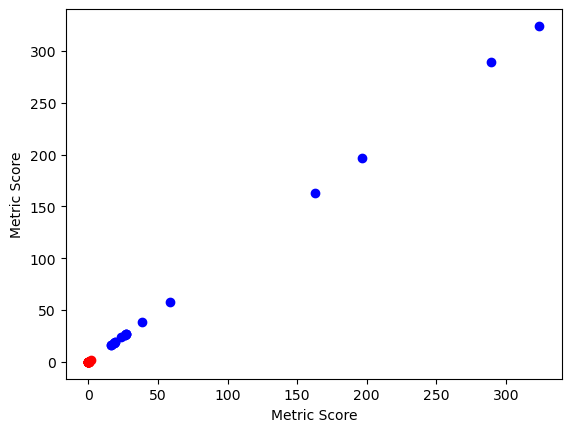

In [186]:

plt.scatter(scores, scores, color='blue', label='Non-random')
plt.scatter(rand_scores, rand_scores, color='red', label='Random')

plt.xlabel('Metric Score')
plt.ylabel('Metric Score')
plt.show()


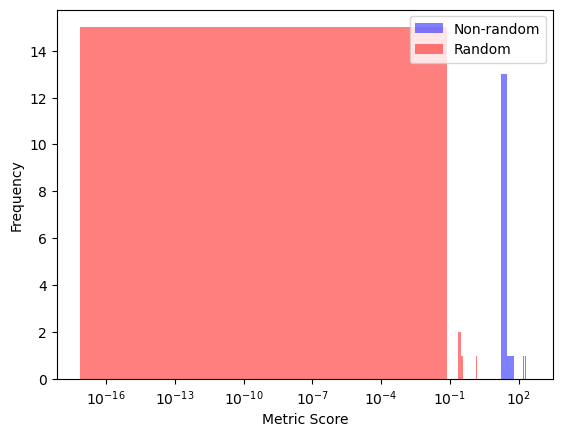

In [187]:

fig, ax = plt.subplots()

ax.hist(scores, bins=20, color='blue', alpha=0.5, label='Non-random')

ax.hist(rand_scores, bins=20, color='red', alpha=0.5, label='Random')

ax.set_xlabel('Metric Score')
ax.set_ylabel('Frequency')
ax.legend()

ax.set_xscale('log') # because otherwise not showing up in same plot for some reason

# Show plot
plt.show()


Obviously this comparison is not very fair and we should make sure that the "functional workflows" are drawn from the same set as the randoms, whereas now they are drawn from a very small subset of very well annotated tools. This is more to show that the comparison works, not that the results are reliable. 

## Visualisation


Using cytoscape to visualise the network (Alma add colouring of the workflow too)

In [179]:

import time # TODO: i switched to datetime, fix this later 
t = time.localtime()
current_time = time.strftime("%Y%m%d%H%M", t)


p4c.create_network_from_igraph(G, f"Cocitations_Size{len(included_tools)}_{current_time}", collection="Citation networks")


print("Styling graph")
p4c.set_node_shape_default("ELLIPSE")
p4c.set_node_width_default(30)
p4c.set_node_height_default(30)
p4c.set_node_border_color_default("#000000")  # Black color in hexadecimal
p4c.set_node_border_width_default(1)
p4c.set_node_color_bypass(included_tools, "#FF0000")  # Red color in hexadecimal
p4c.set_node_size_bypass(included_tools, 100)  # remember it cannot be a np.array, just a list argh 

# colour the tools in the workflow 
p4c.set_node_color_bypass(workflow_tools, "#2F739A")  # they should be gradually coloured later maybe, sequentially
p4c.set_node_size_bypass(workflow_tools, 200)  # remember it cannot be a np.array, just a list argh 


Applying default style...
Applying preferred layout
Styling graph
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.
style_name not specified, so updating "default" style.


''